In [1]:
!conda install jupyter_dashboards -c conda-forge -y

Solving environment: done

## Package Plan ##

  environment location: /Users/williamhan/opt/anaconda3

  added / updated specs:
    - jupyter_dashboards


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.6.15  |       h033912b_0         149 KB  conda-forge
    certifi-2022.6.15          |   py39h6e9494a_0         155 KB  conda-forge
    conda-4.13.0               |   py39h6e9494a_1         986 KB  conda-forge
    jupyter_dashboards-0.7.0   |py39h6e9494a_1003         1.8 MB  conda-forge
    openssl-1.1.1q             |       hfe4f2af_0         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.9 MB

The following NEW packages will be INSTALLED:

  jupyter_dashboards conda-forge/osx-64::jupyter_dashboards-0.7.0-py39h6e9494a_1003

The following packages will be UPDATED:

  ca-c

In [15]:
!pip install osm-runner

In [16]:
import scipy.io as io
import mat73
import pandas as pd
import numpy as np
from ipywidgets import widgets
from IPython.display import clear_output
from arcgis.gis import GIS
from arcgis.raster.functions import *
from arcgis.mapping.ogc import GeoJSONLayer
import time

from osm_runner import Runner  # pip install osm-runner
import pandas as pd

from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project

In [60]:
#Log In
gis = GIS()

#Data
electric_power = GeoJSONLayer('https://services1.arcgis.com/Hp6G80Pky0om7QvQ/arcgis/rest/services/Transmission_Lines_gdb/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')
control_areas = GeoJSONLayer('https://services1.arcgis.com/Hp6G80Pky0om7QvQ/arcgis/rest/services/Control_Area/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')


In [61]:
# def create_map(location, data, toggle)
map1 = gis.map("California, USA")
map1.add_layer(electric_power)

In [63]:
map1

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

In [5]:
# rfts = []
# for idx,props in enumerate(landsat.properties['rasterFunctionInfos']):
#     rfts.append(landsat.properties['rasterFunctionInfos'][idx]['name'])

In [64]:
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer

study_area_dict = {'California':'http://services.arcgis.com/PpEMp4p6SBYbe0zW/arcgis/rest/services/California_Counties/FeatureServer/0',
                   'Montana':'http://services.arcgis.com/iTQUx5ZpNUh47Geb/arcgis/rest/services/Montana_Mask/FeatureServer/0',
                   'Nevada':'http://services.arcgis.com/pGfbNJoYypmNq86F/arcgis/rest/services/28R04_Nevada_Region/FeatureServer/5',
                   'Oregon':'https://services.arcgis.com/uUvqNMGPm7axC2dD/arcgis/rest/services/Oregon_Boundary_generalized/FeatureServer/0',
                   'Texas':'http://services2.arcgis.com/5MVN2jsqIrNZD4tP/arcgis/rest/services/Texas_Outline/FeatureServer/0',
                   'Mississippi': 'https://services.arcgis.com/jDGuO8tYggdCCnUJ/arcgis/rest/services/Mississippi_State_Border/FeatureServer'
                  }

study_areas = ['California',
               'Montana',
               'Nevada',
               'Oregon',
               'Texas',
              'Mississippi']

country = widgets.Dropdown(
    options=study_areas,
    value='California',
    description='Region to Process:',
    disabled=False,
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        location = geocode(str(country.value) + ', USA')[0]
        map1.extent = location['extent']
        #fl = FeatureLayer(study_area_dict[country.value])
        #map1.extent = fl.properties['extent']
        #print("changed to %s" % change['new'])

country.observe(on_change)

display(country)

Dropdown(description='Region to Process:', options=('California', 'Montana', 'Nevada', 'Oregon', 'Texas', 'Mis…

In [10]:
# from datetime import datetime

# def on_button_click(b):
#     #map1.extentx = getextent
#     clear_output()
#     print("Job submitted at " + f"{datetime.now():%Y-%m-%d %H:%M:%S}")

# button = widgets.Button(description="Run Raster Analytics", 
#                         disabled=False,
#                         button_style='success',
#                         tooltip='Kick Off A Raster Analytics Job',
#                         icon='check')
# display(button)
# button.on_click(on_button_click)

Job submitted at 2022-07-14 08:02:53


In [66]:
control = FeatureLayer('https://services1.arcgis.com/Hp6G80Pky0om7QvQ/ArcGIS/rest/services/Control_Area/FeatureServer/0')
control_df = GeoAccessor.from_layer(control)
control_df = control_df.iloc[2, :]
control_df = pd.DataFrame(control_df)
display(control_df.head())

control_extent = control_df.spatial.full_extent
control_coords = project([[control_extent[0], control_extent[1]], [control_extent[2], control_extent[3]]], in_sr=3857, out_sr=4326)
control_bounds = f"({control_coords[0]['y']},{control_coords[0]['x']},{control_coords[1]['y']},{control_coords[1]['x']})"



,2
OBJECTID,3
ID,317
NAME,"ALCOA POWER GENERATING, INC. - YADKIN DIVISION"
ADDRESS,201 ISABELLA ST. SUITE 500
CITY,PITTSBURG


KeyError: None

In [40]:
control_df = control_df.iloc[2, :]


In [45]:
control_df = pd.DataFrame(control_df).T
control_df

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TELEPHONE,COUNTRY,NAICS_CODE,...,PLAN_OUT,UNPLAN_OUT,OTHER_OUT,TOTAL_CAP,PEAK_LOAD,MIN_LOAD,GlobalID,Shape__Area,Shape__Length,SHAPE
2,3,317,"ALCOA POWER GENERATING, INC. - YADKIN DIVISION",201 ISABELLA ST. SUITE 500,PITTSBURG,PA,NOT AVAILABLE,(412) 315-2900,USA,2211,...,0.0,0.0,0.0,219.0,10.0,1.0,2abef5f2-993a-4e61-acff-fe26a00cf8d7,0.084103,1.300929,"{'rings': [[[-80.0587501529999, 35.689912796],..."


In [46]:
control_extent = control_df.spatial.full_extent
control_coords = project([[control_extent[0], control_extent[1]], [control_extent[2], control_extent[3]]], in_sr=3857, out_sr=4326)
control_bounds = f"({control_coords[0]['y']},{control_coords[0]['x']},{control_coords[1]['y']},{control_coords[1]['x']})"


In [47]:
df_geoextent_geom = control_df.spatial.bbox

In [52]:
pr_fl = FeatureLayer('https://services1.arcgis.com/Hp6G80Pky0om7QvQ/ArcGIS/rest/services/Control_Area/FeatureServer/0')
pr_df = GeoAccessor.from_layer(pr_fl)
display(pr_df.head())

pr_extent = pr_df.spatial.full_extent
pr_coords = project([[pr_extent[0], pr_extent[1]], [pr_extent[2], pr_extent[3]]], in_sr=2154, out_sr=4326)
pr_bounds = f"({pr_coords[0]['y']},{pr_coords[0]['x']},{pr_coords[1]['y']},{pr_coords[1]['x']})"

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TELEPHONE,COUNTRY,NAICS_CODE,...,PLAN_OUT,UNPLAN_OUT,OTHER_OUT,TOTAL_CAP,PEAK_LOAD,MIN_LOAD,GlobalID,Shape__Area,Shape__Length,SHAPE
0,1,1,NEW BRUNSWICK SYSTEM OPERATOR,515 KING STREET,FREDERICTON,NB,E3B 4X1,(800) 663-6272,CAN,2211,...,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,a7eae21e-6142-48fd-8735-6ec524946cf8,3.345375,16.716289,"{""rings"": [[[-69.22417, 47.4597000000001], [-6..."
1,2,189,POWERSOUTH ENERGY COOPERATIVE,2027 EAST THREE NOTCH STREET,ANDALUSIA,AL,36421,(334) 427-3000,USA,2211,...,2.0,8.0,0.0,2768.0,1991.0,576.0,2bd26c82-3d4e-4a1e-973a-bcb31f3b56b9,6.894513,42.272140,"{""rings"": [[[-87.51973, 30.2830200000001], [-8..."
2,3,317,"ALCOA POWER GENERATING, INC. - YADKIN DIVISION",201 ISABELLA ST. SUITE 500,PITTSBURG,PA,NOT AVAILABLE,(412) 315-2900,USA,2211,...,0.0,0.0,0.0,219.0,10.0,1.0,2abef5f2-993a-4e61-acff-fe26a00cf8d7,0.084103,1.300929,"{""rings"": [[[-80.0587501529999, 35.689912796],..."
3,4,599,ANCHORAGE MUNICIPAL LIGHT & POWER,1200 EAST FIRST AVENUE,ANCHORAGE,AK,99501,(435) 477-3331,USA,2211,...,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,2f057d0b-d43a-45ae-9fe1-9a5b3475b446,0.745069,7.026545,"{""rings"": [[[-153.97266, 57.53972], [-153.9720..."
4,5,803,ARIZONA PUBLIC SERVICE COMPANY,MS # 9997,PHOENIX,AZ,85072,NOT AVAILABLE,USA,2211,...,0.0,784.0,0.0,9030.0,7030.0,3155.0,049a49de-1a5d-46a4-9cb1-19107832d477,12.435030,30.529306,"{""rings"": [[[-109.280715072, 31.5372603230001]..."


In [57]:
map1.draw(control_df.iloc[0].SHAPE)
map1.draw(control_df.spatial.bbox)

display(map1)

print(f'Searching Area: {round(control_df.spatial.bbox.area / 1000000)} Square Kilometers')

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

Searching Area: 0 Square Kilometers


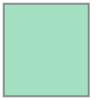

In [59]:
control_df.spatial.bbox